In [1]:
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms

import datasets
import models

import matplotlib.pyplot as plt
import numpy as np

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from skimage.transform import resize

from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)

import scipy
import scipy.misc
import random

## Model

In [2]:
low_dim = 128
checkpoint = torch.load('model_best_epoch120.pth.tar') #torch.load('checkpoint.pth.tar')
model = models.__dict__[checkpoint['arch']](low_dim=low_dim)

state_dict = checkpoint['state_dict']

from collections import OrderedDict

print('epoch: {}'.format(checkpoint['epoch']))
print('best prec1: {}'.format(checkpoint['best_prec1']))

lemniscate = checkpoint['lemniscate']

new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v

# load params
model.load_state_dict(new_state_dict)
model = model.cuda()

epoch: 121
best prec1: 0.8931


## Data

In [3]:
data_dir = '/home/bala/lemniscate_vis/data/'
train_trans = transforms.Compose([transforms.Resize(300),
                                  transforms.RandomResizedCrop(224),
                                  transforms.ToTensor(),
                                  transforms.Normalize((.5,), (1,))])

val_trans = transforms.Compose([transforms.Resize(224),
                                transforms.ToTensor(),
                                transforms.Normalize((.5,), (1,))])


train_dataset = datasets.MNISTInstance(root=data_dir, train=True, transform=train_trans, download=True)
val_dataset = datasets.MNISTInstance(root=data_dir, train=False, transform=val_trans, download=True)

In [4]:
batch_size = 32
workers = 0
train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=False,
        num_workers=workers, pin_memory=True, sampler=None)

val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False,
        num_workers=workers, pin_memory=True)

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


(array([ 106.,  100.,   92.,   87.,   95.,   90.,   86.,  110.,  100.,   94.]),
 array([  9.00000000e+00,   1.00700000e+03,   2.00500000e+03,
          3.00300000e+03,   4.00100000e+03,   4.99900000e+03,
          5.99700000e+03,   6.99500000e+03,   7.99300000e+03,
          8.99100000e+03,   9.98900000e+03]),
 <a list of 10 Patch objects>)

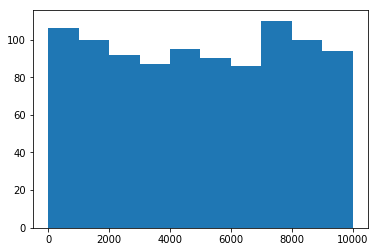

In [5]:
all_targets = []
all_indices = []

stop_ind = 30
for i, (input, targets, index) in enumerate(val_loader):
    if i < stop_ind:
        all_targets.append(np.array(targets))
        all_indices.append(np.array(index))

all_targets = np.array(all_targets)
all_indices = np.array(all_indices)
plt.hist(all_indices.flatten())

In [6]:
all_indices

array([[5679, 1210,  533, 8861,  464, 7308, 8278, 9455, 6960, 9345, 9436,
        5745, 7833, 1466, 3693, 9678, 4882,  144, 2235, 3318, 6827,  974,
        8493,  323, 4480, 8027, 1815, 1445, 4906, 1851, 3320,  353],
       [4080,  308, 7781, 5194, 4137,   50, 7174, 7436, 6149, 3787, 9989,
        8614, 7326, 8012, 8970,  331, 7065, 1703, 5688, 6692, 4878, 7161,
         610,  240, 1479, 4242, 4009, 6839, 6445, 8186, 9539, 6745],
       [5488, 1650, 5041,  662, 1856, 2070, 2203,  903, 5959, 9830, 7611,
         887, 5690, 1747, 3065, 3510, 6901, 3246, 4206, 5371, 9234, 2076,
        4719, 1722, 8573, 5382, 6673, 8971, 7716, 2300, 4402, 5476],
       [ 972, 9609, 2256, 9657, 8843, 8247, 6147,  286, 8622, 1322, 3369,
         150, 6712,  644,  923, 4306, 8523, 3572, 3281, 6029, 9588,  552,
        1876, 2000, 6270, 1555, 1395, 9374, 9753, 8214, 7934, 8839],
       [5770,   78, 9371, 2155, 4277, 9566, 6943, 5149, 7338,  661, 1044,
        8767, 6275, 1089,  812, 3112, 1592, 7345, 4272, 45

In [7]:
best_imgs = np.zeros((128, 10, 224, 224))
best_acts = np.zeros((128, 10))

all_acts = None
all_imgs = None
all_labels = None

for i, (input, targets, index) in enumerate(val_loader):
        index = index.cuda(async=True)
        input = input.cuda()

        # compute output
        feature = model(input)
        
        if all_acts is None:
            all_acts = feature.data.cpu().numpy()
            all_imgs = input.data.cpu().numpy()
            all_labels = targets.data.cpu().numpy()
        else:
            feats = feature.data.cpu().numpy()
            imgs = input.data.cpu().numpy()
            targets = targets.data.cpu().numpy()
            
            all_acts = np.vstack((all_acts, feats))
            all_imgs = np.concatenate((all_imgs, imgs), axis = 0)
            all_labels = np.concatenate((all_labels, targets))
        
        #print(input.shape)
        #print(feature.shape)
all_imgs = all_imgs[:,0,:,:]

## Analysis

### TSNE

In [8]:
tsne = TSNE()
tsne_results = tsne.fit_transform(all_acts)

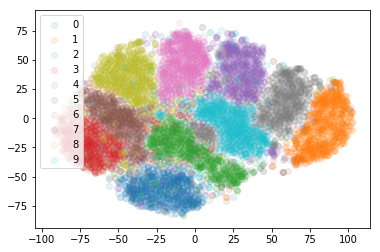

In [9]:
f, ax = plt.subplots()
#for i in range(10000)[0:10]:
for i in range(10):
    ax.scatter(tsne_results[all_labels == i, 0], tsne_results[all_labels == i, 1], label = i, alpha=.1)
ax.legend()

In [10]:
all_imgs.shape

(10000, 224, 224)

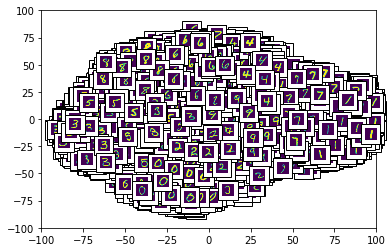

In [11]:
fig, ax = plt.subplots()

# Define a 2nd position to annotate (don't display with a marker this time)
for ind in range(10000):
    arr_img = all_imgs[ind]
    xy = tsne_results[ind]
    imagebox = OffsetImage(arr_img, zoom=0.05)
    imagebox.image.axes = ax

    ab = AnnotationBbox(imagebox, xy)

    ax.add_artist(ab)

    # Fix the display limits to see everything
    ax.set_xlim(-100, 100)
    ax.set_ylim(-100, 100)

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


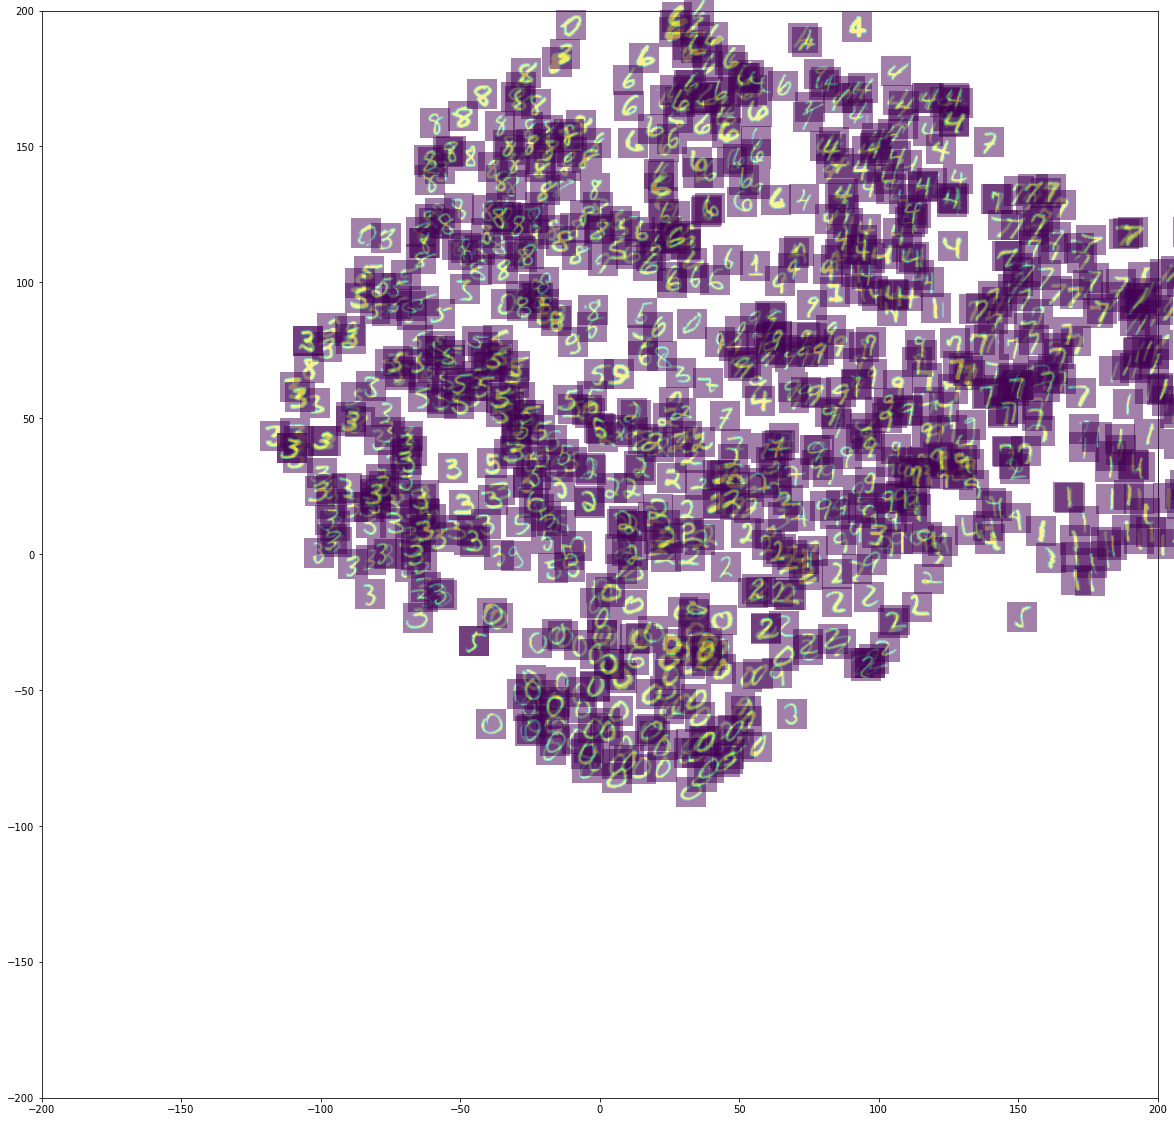

In [12]:
fig, ax = plt.subplots()
fig.set_size_inches(20,20)
new_len = 30
off = 5

# Define a 2nd position to annotate (don't display with a marker this time)
for ind in range(1000):
    arr_img = np.copy(all_imgs[ind])
    arr_img = resize(arr_img, (new_len, new_len))
    
    xy = tsne_results[ind]
    
    #imagebox = OffsetImage(arr_img, zoom=0.05)
    #imagebox.image.axes = ax

    #ab = AnnotationBbox(imagebox, xy)
    
    
    fig.figimage(arr_img, fig.bbox.xmax/2 + off*xy[0], fig.bbox.ymax/2 + off*xy[1], zorder=10, origin='upper', alpha=.5)
    #ax.add_artist(ab)

    # Fix the display limits to see everything
    ax.set_xlim(-200, 200)
    ax.set_ylim(-200, 200)

### Top X Images Per Final Layer Neuron

In [13]:
act_sort = np.argsort(all_acts, axis=0)

[[ 2977.  6636.  8683. ...,  4848.   320.  1236.]
 [ 9348.  4053.  9121. ...,  1320.  2021.  6798.]
 [ 8950.  3324.   183. ...,  1056.  8783.  9102.]
 ..., 
 [    0.     0.     0. ...,     0.     0.     0.]
 [    0.     0.     0. ...,     0.     0.     0.]
 [    0.     0.     0. ...,     0.     0.     0.]]


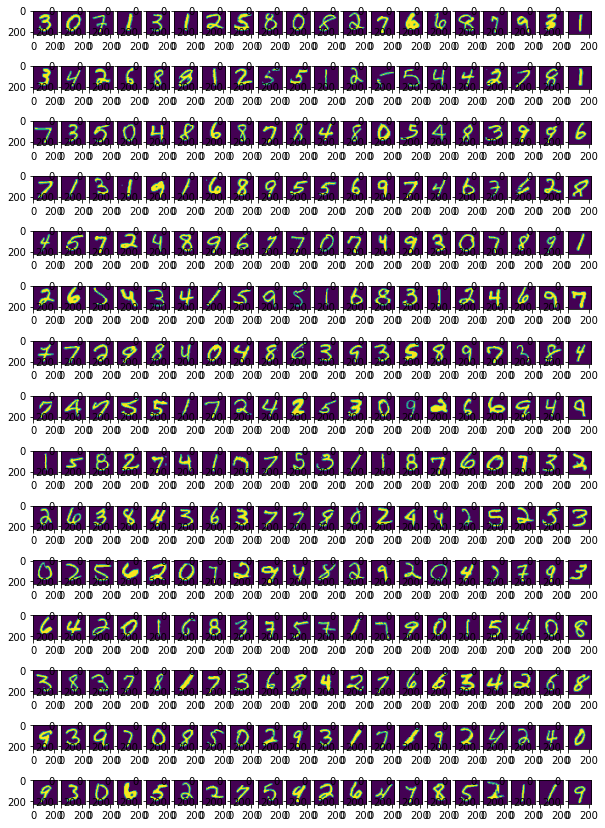

In [14]:
num_dims = 15
num_top = 20

f, axes = plt.subplots(num_dims, num_top)
f.set_size_inches(10, 15)

range_arr = np.arange(10000)
feat_sort_arr = np.zeros((128, num_top))
for dim_id, dim in enumerate(range(128)[0:num_dims]):
    #for top_ind, rank in enumerate(range(10000 - num_top, 10000)[::-1]):
    for top_ind, rank in enumerate([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 9990, 9991, 9992, 9993, 9994, 9995, 9996, 9997, 9998, 9999]):
        arg_val = range_arr[act_sort[:,dim] == rank][0]
        
        feat_sort_arr[dim, top_ind] = arg_val
        
        axes[dim, top_ind].imshow(all_imgs[arg_val])
        
print(feat_sort_arr)

### Top X Images Per Final Layer PC

In [15]:
num_pcs = 15
pca = PCA(n_components=num_pcs)
pca = pca.fit(all_acts)

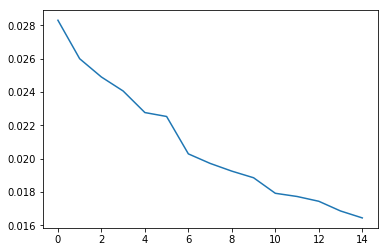

In [16]:
plt.plot(range(len(pca.explained_variance_)), pca.explained_variance_)

In [17]:
num_bot = 10
num_top = 10

bot_pca_sim = np.zeros((num_pcs, num_bot)) # bot 10 cosine similarity scores per pc
bot_pca_imgs = np.zeros((num_pcs, num_bot, 224, 224))

top_pca_sim = np.zeros((num_pcs, num_top)) # top 10 cosine similarity scores per pc
top_pca_imgs = np.zeros((num_pcs, num_top, 224, 224))


for ind in range(10000):
    act = all_acts[ind]
    img = all_imgs[ind]
    
    for comp_ind in range(num_pcs):
        pca_comp = pca.components_[comp_ind]
        cos_sim = np.dot(pca_comp, act)
        
        new_arr_bot = np.zeros(num_bot+1)
        new_imgs_bot = np.zeros((num_bot+1, 224, 224)) 
        
        new_arr_bot[0:num_bot] = bot_pca_sim[comp_ind]
        new_arr_bot[-1] = cos_sim
        
        new_imgs_bot[0:num_bot, :, :] = bot_pca_imgs[comp_ind]
        new_imgs_bot[-1, :, :] = img
        
        new_args_bot = np.argsort(new_arr_bot)
        
        
        new_arr_top = np.zeros(num_top+1)
        new_imgs_top = np.zeros((num_top+1, 224, 224)) 
        
        new_arr_top[0:num_top] = top_pca_sim[comp_ind]
        new_arr_top[-1] = cos_sim
        
        new_imgs_top[0:num_top, :, :] = top_pca_imgs[comp_ind]
        new_imgs_top[-1, :, :] = img
        
        new_args_top = np.argsort(new_arr_top)
        
        for bot_ind, rank in enumerate(range(num_bot)):
            bot_pca_sim[comp_ind, bot_ind] = new_arr_bot[new_args_bot == rank][0]
            bot_pca_imgs[comp_ind, bot_ind, :, :] = new_imgs_bot[new_args_bot == rank, :, :][0]
        
        for top_ind, rank in enumerate(range(num_top+1)[::-1][0:num_top]):
            top_pca_sim[comp_ind, top_ind] = new_arr_top[new_args_top == rank][0]
            top_pca_imgs[comp_ind, top_ind, :, :] = new_imgs_top[new_args_top == rank, :, :][0]
        

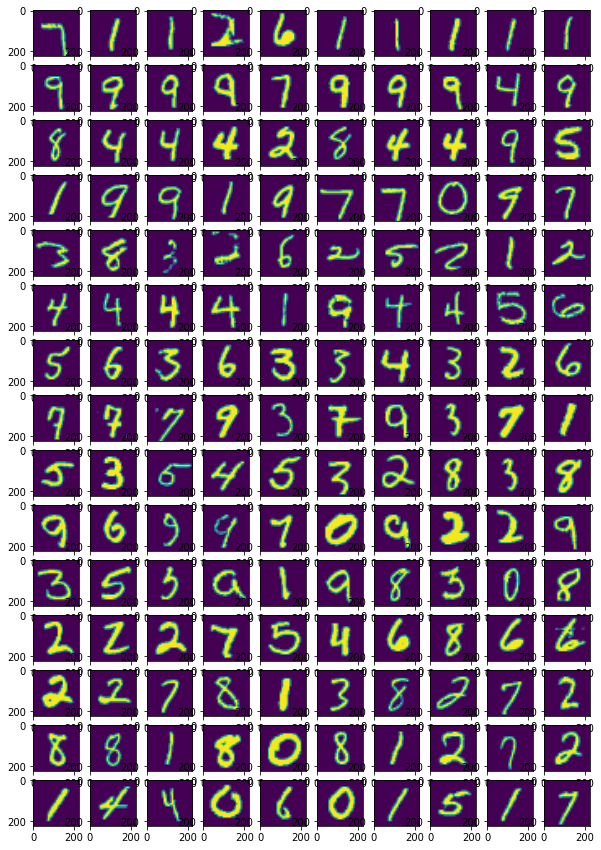

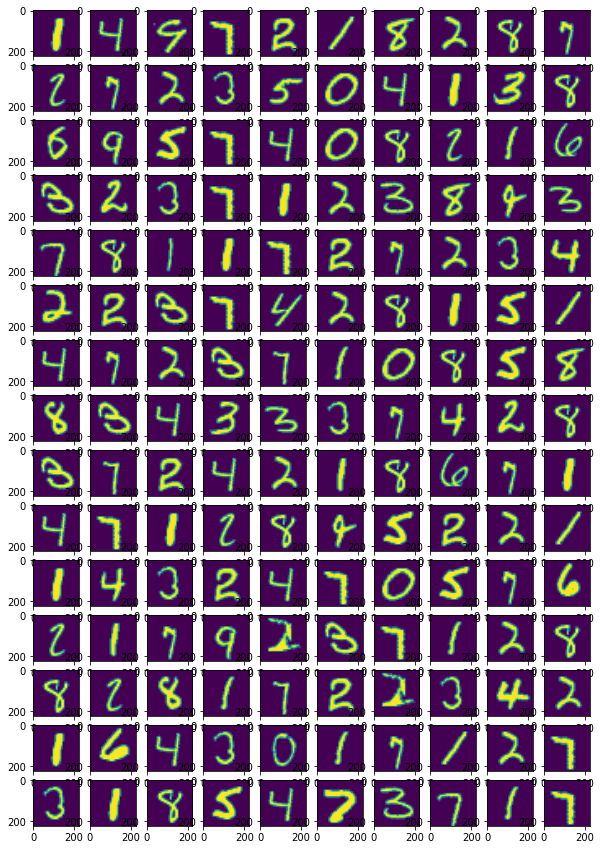

In [18]:
f, axes = plt.subplots(num_pcs, num_bot)
f.set_size_inches(10, 15)

for pc_ind in range(num_pcs):
    for bot_ind in range(num_bot):
        axes[pc_ind, bot_ind].imshow(bot_pca_imgs[pc_ind, bot_ind])

f, axes = plt.subplots(num_pcs, num_top)
f.set_size_inches(10, 15)

for pc_ind in range(num_pcs):
    for top_ind in range(num_top):
        axes[pc_ind, top_ind].imshow(top_pca_imgs[pc_ind, top_ind])

### Rotation Along Feature Sphere

theta: 74.27471454438525
-0.226265
-0.191231
-0.152987
-0.112176
-0.123931
-0.139797
-0.153317
-0.164265
-0.172456
-0.177752
-0.180066

theta: 86.69213505925183
-0.15869
-0.1258
-0.112401
-0.12015
-0.125154
-0.127299
-0.132248
-0.150987
-0.166276
-0.185445
-0.227662

theta: 80.55770993923159
-0.177289
-0.162099
-0.14502
-0.144989
-0.14888
-0.149833
-0.150705
-0.170154
-0.186246
-0.202378
-0.24805

theta: 74.80261303514635
-0.184848
-0.145953
-0.146115
-0.161364
-0.173867
-0.190289
-0.217877
-0.241757
-0.261522
-0.276836
-0.287438

theta: 76.4749575326673
-0.204945
-0.190693
-0.173048
-0.152326
-0.133247
-0.141879
-0.147987
-0.151462
-0.152243
-0.167887
-0.195176

theta: 87.19219369895596
-0.143516
-0.123238
-0.125485
-0.125805
-0.128271
-0.127771
-0.124319
-0.141857
-0.1707
-0.207896
-0.240287

theta: 79.97265642549581
-0.200841
-0.186306
-0.168147
-0.146717
-0.122434
-0.0957693
-0.0992844
-0.116289
-0.136994
-0.169985
-0.208422

theta: 75.64256237851784
-0.138756
-0.106522
-0.0907336


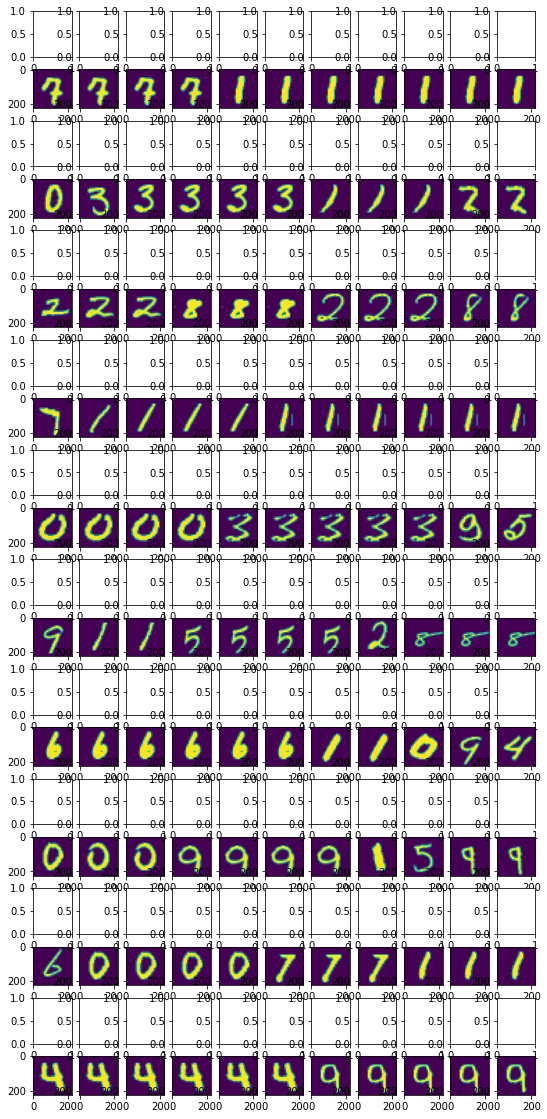

In [19]:
num_comps = 10
num_mid = 9
f, axes = plt.subplots(2*num_comps, 2+num_mid)
f.set_size_inches(9,20)

for comp_id in range(num_comps):
    r1 = random.randint(0, all_acts.shape[0] - 1)
    r2 = random.randint(0, all_acts.shape[0] - 1)

    f1 = all_acts[r1]
    f2 = all_acts[r2]

    img1 = all_imgs[r1]
    img2 = all_imgs[r2]

    theta = np.arccos(np.dot(f1, f2))
    print('theta: {}'.format(theta*360/(2*np.pi)))

    step = 1./(num_mid+1)

    #axes[comp_id, 0].imshow(img1)
    
    for mid_ind, t in enumerate(np.arange(0, 1+step, step)):
        #print(t)
        ft = (1/(np.sin(theta)))*(f1*np.sin((1-t)*theta) + f2*np.sin((t)*theta))

        all_sims = np.dot(all_acts, ft)

        closest_args = np.argsort(all_sims)

        closest_img = all_imgs[closest_args[0]]
        print(all_sims[closest_args[0]])
        
        axes[2*comp_id + 1, mid_ind].imshow(closest_img)
        
    print('')

    #axes[comp_id, 1+num_mid].imshow(img2)

In [20]:
len(np.arange(0, 1+step, step))

11

(array([  8.60000000e+01,   9.11000000e+02,   3.26900000e+03,
          3.74800000e+03,   1.66700000e+03,   2.90000000e+02,
          2.60000000e+01,   2.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([-0.19120266, -0.07208237,  0.04703792,  0.16615821,  0.2852785 ,
         0.40439879,  0.52351908,  0.64263937,  0.76175966,  0.88087995,
         1.00000024]),
 <a list of 10 Patch objects>)

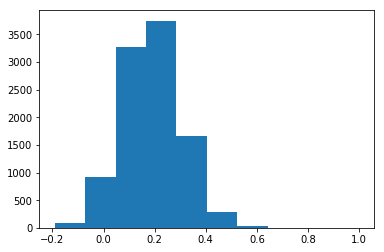

In [21]:
plt.hist(np.dot(all_acts,f2).flatten())

percentiles at 10, 25, 50, 75, 90: [ 70.90229566  75.21894039  79.79261947  84.18426206  87.87260485]


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in arccos
  # This is added back by InteractiveShellApp.init_path()


(array([  2.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   2.00000000e+00,   7.00000000e+01,
          9.29000000e+02,   4.71200000e+03,   3.92400000e+03,
          3.61000000e+02]),
 array([   0.        ,   10.12973061,   20.25946123,   30.38919184,
          40.51892246,   50.64865307,   60.77838369,   70.9081143 ,
          81.03784492,   91.16757553,  101.29730615]),
 <a list of 10 Patch objects>)

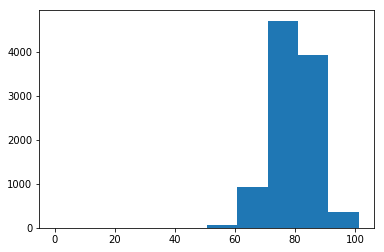

In [22]:
num_to_test = 10000
thetas = []

for i in range(num_to_test):
    r1 = random.randint(0, all_acts.shape[0]-1)
    r2 = random.randint(0, all_acts.shape[0]-1)

    f1 = all_acts[r1]
    f2 = all_acts[r2]

    theta = np.arccos(np.dot(f1, f2))
    theta = theta*360/(2*np.pi)
    thetas.append(theta)
    
thetas = np.array(thetas)
thetas[np.isnan(thetas)] = 0

print('percentiles at 10, 25, 50, 75, 90: {}'.format(np.percentile(thetas, np.array([10, 25, 50, 75, 90]))))

plt.hist(thetas)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in arccos
  


percentiles for 0 at 10, 25, 50, 75, 90: [ 64.5466093   70.15419802  76.07945543  81.4863749   86.16698777]
percentiles for 1 at 10, 25, 50, 75, 90: [ 65.30637495  71.88904387  77.66210588  82.86067727  87.242399  ]
percentiles for 2 at 10, 25, 50, 75, 90: [ 66.50352133  71.81639969  77.26462644  82.09910434  86.22274124]
percentiles for 3 at 10, 25, 50, 75, 90: [ 64.31207836  69.7934667   75.55153645  80.73717316  85.1440276 ]
percentiles for 4 at 10, 25, 50, 75, 90: [ 65.96422394  71.52022903  77.0671725   82.09992055  86.30060608]
percentiles for 5 at 10, 25, 50, 75, 90: [ 65.14002023  70.78276155  76.34636556  81.30079525  85.64425222]
percentiles for 6 at 10, 25, 50, 75, 90: [ 65.0315821   70.41395182  76.05282452  80.9230209   85.41968243]
percentiles for 7 at 10, 25, 50, 75, 90: [ 67.00221667  72.80889618  78.55846234  83.82655139  88.04234256]
percentiles for 8 at 10, 25, 50, 75, 90: [ 65.85503858  71.10678401  76.5756516   81.64881558  86.07871167]
percentiles for 9 at 10, 25,

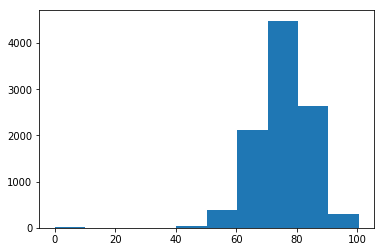

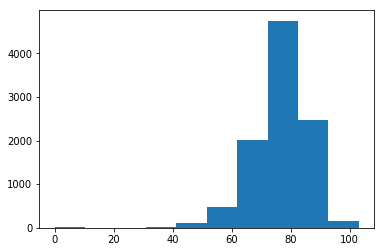

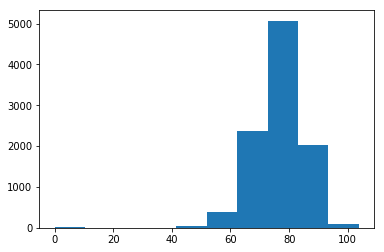

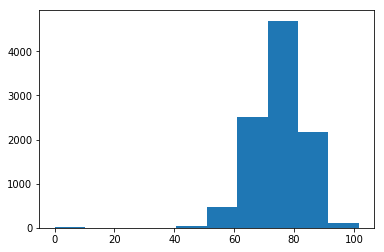

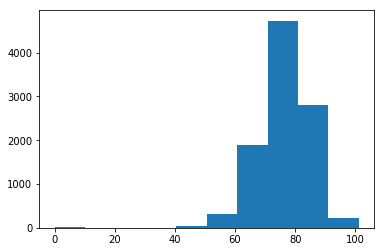

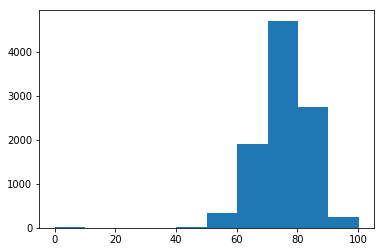

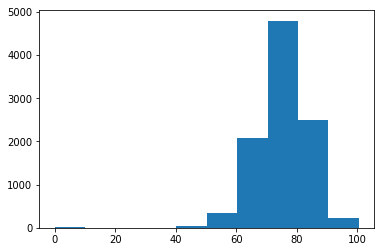

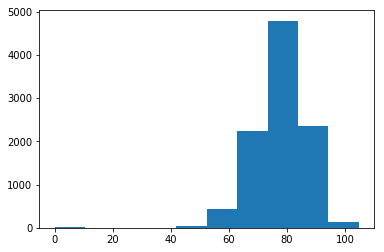

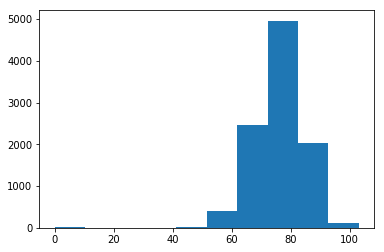

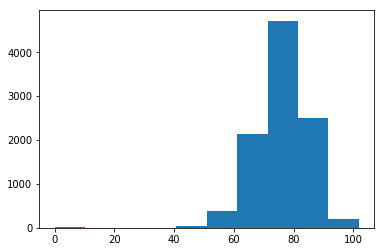

In [23]:
for i in range(10): # num labels
    class_acts = all_acts[all_labels==i]
    
    num_to_test = 10000
    thetas = []

    for j in range(num_to_test):
        r1 = random.randint(0, class_acts.shape[0]-1)
        r2 = random.randint(0, class_acts.shape[0]-1)

        f1 = class_acts[r1]
        f2 = class_acts[r2]

        theta = np.arccos(np.dot(f1, f2))
        theta = theta*360/(2*np.pi)
        thetas.append(theta)

    thetas = np.array(thetas)
    
    
    thetas[np.isnan(thetas)] = 0

    print('percentiles for {} at 10, 25, 50, 75, 90: {}'.format(i, np.percentile(thetas, np.array([10, 25, 50, 75, 90]))))
    
    f, ax = plt.subplots()
    ax.hist(thetas)

In [24]:
class_acts = all_acts[all_labels==5]

percentiles at 0 for 10, 25, 50, 75, 90: [ 71.73529666  75.76545968  80.30112364  84.43301926  88.23608225]
percentiles at 1 for 10, 25, 50, 75, 90: [ 73.16252889  77.16316398  81.33358186  85.46382457  89.03422059]
percentiles at 2 for 10, 25, 50, 75, 90: [ 71.61769651  75.61773293  79.99243665  84.2270993   88.15006148]
percentiles at 3 for 10, 25, 50, 75, 90: [ 71.00000425  75.09110315  79.69757397  83.89605881  87.55584185]
percentiles at 4 for 10, 25, 50, 75, 90: [ 71.72363274  75.84651695  80.18585395  84.394929    88.18880368]
percentiles at 5 for 10, 25, 50, 75, 90: [ 70.86479451  75.05791697  79.5292542   83.76796544  87.41401024]
percentiles at 6 for 10, 25, 50, 75, 90: [ 71.65825007  75.63311623  79.92589012  84.03733615  87.82774553]
percentiles at 7 for 10, 25, 50, 75, 90: [ 72.10911837  76.21165716  80.58340511  84.97131671  88.61637079]
percentiles at 8 for 10, 25, 50, 75, 90: [ 71.21303717  75.35700583  79.73015739  84.14522411  87.93855374]
percentiles at 9 for 10, 25,

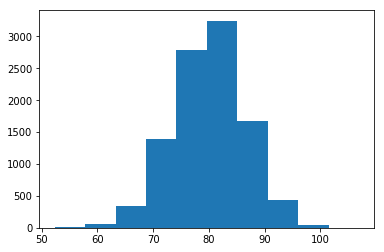

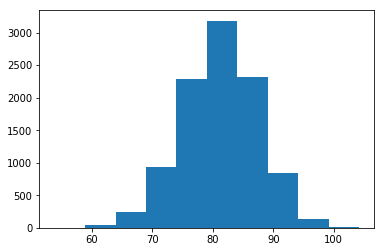

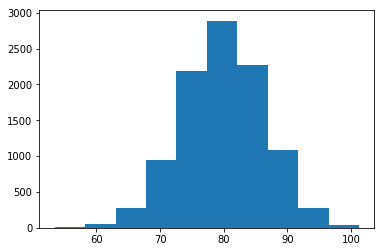

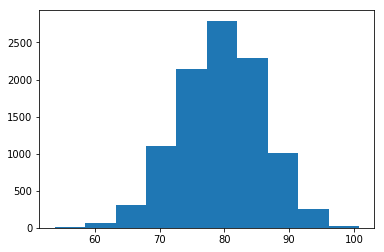

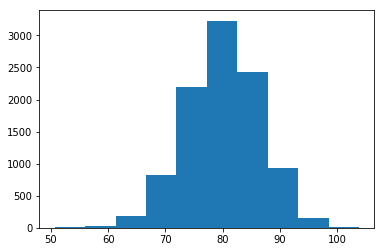

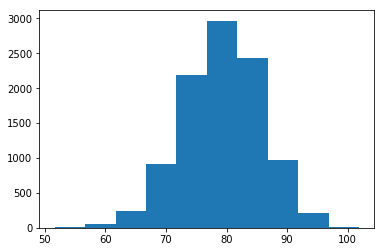

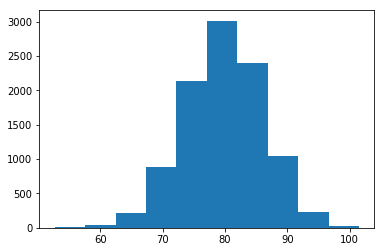

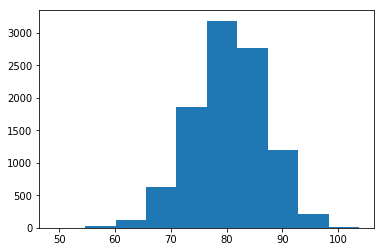

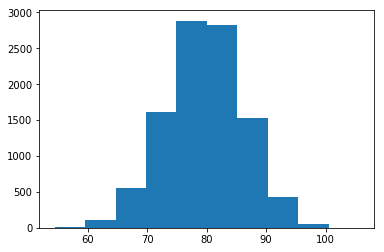

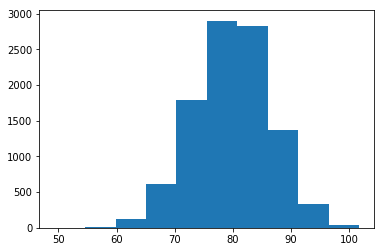

In [25]:
for i in range(10): # num labels
    class_acts = all_acts[all_labels==i]
    not_class_acts = all_acts[~(all_labels==i)]
    
    num_to_test = 10000
    thetas = []

    for j in range(num_to_test):
        r1 = random.randint(0, class_acts.shape[0]-1)
        r2 = random.randint(0, not_class_acts.shape[0]-1)

        f1 = class_acts[r1]
        f2 = not_class_acts[r2]

        theta = np.arccos(np.dot(f1, f2))
        theta = theta*360/(2*np.pi)
        thetas.append(theta)

    thetas = np.array(thetas)
    
    
    thetas[np.isnan(thetas)] = 0

    print('percentiles at {} for 10, 25, 50, 75, 90: {}'.format(i, np.percentile(thetas, np.array([10, 25, 50, 75, 90]))))
    
    f, ax = plt.subplots()
    ax.hist(thetas)